# Toy problem for model discrepancy

## tl;dr
> In this notebook we apply approximate Bayesian computation with a stochastic distance kernel composed of 
> a Gaussian likelihood with variance equal to measurement uncertainty and additional variance due to model
> discrepancy (the latter of which is calibrated in addition to model parameters). We use a toy problem to
> demonstrate that a naive model will produce a non-zero model posterior distribution for this model discrepancy
> variance, while the true model will tend to zero.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyabc

In [2]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

The true model is $\zeta(x)=\frac{\theta x}{1+x/a}$.

We use a naive model $\eta(x)=\theta x$ to try to infer the model discrepancy.

In [3]:
theta_true = {'theta': 0.65, 'a': 20}
noise_sd = 0.01
x = np.linspace(0.4, 4., 11)

In [4]:
def model_true(pars):
    if 'a' not in pars:
        a = 20
    else:
        a = pars['a']
    sol = pars['theta']*x/(1+x/a)
    return {'Y': sol}

true_trajectory = model_true(theta_true)

In [5]:
def model_naive(pars):
    sol = pars['theta']*x
    return {'Y': sol}

Generate some observational data using the true model with white noise $\sigma_e^2=0.01^2$.

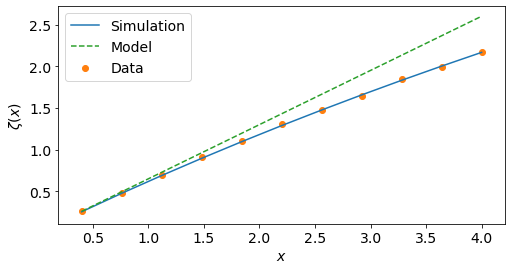

In [6]:
def generate_data(pars, sigma=noise_sd):
    sim = model_true(pars)
    return {'Y': sim['Y'] + sigma*np.random.randn(len(x))}

measured_data = generate_data(theta_true)
naive_estimate = model_naive({'theta': 0.65})

# plot data
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x, true_trajectory['Y'], color="C0", label='Simulation')
ax.plot(x, naive_estimate['Y'], color="C2", linestyle='--', label='Model')
ax.scatter(x, measured_data['Y'],
            color="C1", label='Data')
ax.set_xlabel('$x$')
ax.set_ylabel('$\zeta(x)$')
ax.legend(loc='upper left')
fig.show()

## "Standard" ABC

We try running standard ABC-SMC on this problem. In this case we have a uniform acceptance kernel that gradually reduces the width of the uniform error distribution assumed around the measurements [Wilkinson2013].

In [7]:
# sum absolute distance between all measurements
def distance(simulation, data):
    return sp.absolute(data["Y"] - simulation["Y"]).sum()
# standard uniform acceptor if distance is less than threshold
acceptor = pyabc.acceptor.UniformAcceptor()
# computational settings
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=16)
#sampler = pyabc.sampler.SingleCoreSampler()
population_size = pyabc.ConstantPopulationSize(nr_particles=100)
# local transition
transition = pyabc.LocalTransition()

In [8]:
# assume a uniform prior on the slope parameter
limits = {'theta': (0., 1.)}
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", a, b - a)
                           for key, (a,b) in limits.items()})

In [9]:
abc = pyabc.ABCSMC(model_naive, prior, distance, 
                   acceptor=acceptor,
                   sampler=sampler,
                   population_size=population_size,
                   transitions=transition)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history = abc.run(max_nr_populations=20)

INFO:History:Start <ABCSMC(id=247, start_time=2019-12-04 11:10:45.654033, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 6.725695795392419
INFO:ABC:t: 0, eps: 6.725695795392419.
INFO:ABC:Acceptance rate: 100 / 170 = 5.8824e-01.
INFO:ABC:t: 1, eps: 3.4673979579246077.
INFO:ABC:Acceptance rate: 100 / 246 = 4.0650e-01.
INFO:ABC:t: 2, eps: 1.7230068860817565.
INFO:ABC:Acceptance rate: 100 / 194 = 5.1546e-01.
INFO:ABC:t: 3, eps: 1.0407423071329314.
INFO:ABC:Acceptance rate: 100 / 224 = 4.4643e-01.
INFO:ABC:t: 4, eps: 0.6865073999711462.
INFO:ABC:Acceptance rate: 100 / 225 = 4.4444e-01.
INFO:ABC:t: 5, eps: 0.5980466771875763.
INFO:ABC:Acceptance rate: 100 / 203 = 4.9261e-01.
INFO:ABC:t: 6, eps: 0.5682928187836377.
INFO:ABC:Acceptance rate: 100 / 199 = 5.0251e-01.
INFO:ABC:t: 7, eps: 0.5567683564581811.
INFO:ABC:Acceptance rate: 100 / 229 = 4.3668e-01.
INFO:ABC:t: 8, eps: 0.5500312213932916.
INFO:ABC:Acceptance rate: 100 / 244 = 4.0984e-01.
INFO:ABC:t:

Plotting the evolution of the approximate posterior distribution for $\theta$ shows that is converges onto the incorrect value but with a low posterior width.

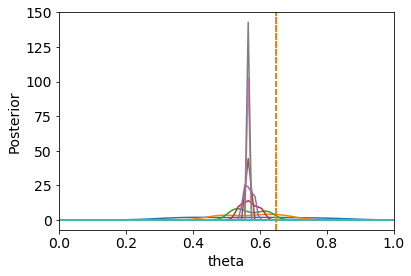

In [10]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="theta", t=t, refval=theta_true,
        xmin=0, xmax=1, numx=100, ax=ax)

We can plot sampled output from the prior, posterior and the accepted samples to illustrate the inferred model.

In [11]:
from pyabc.transition import MultivariateNormalTransition
import pandas as pd

def plot_samples(history, model, prior, measured_data=None, n_samples=10):
    fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True)
    fig.set_size_inches(15, 3)
    n = n_samples  # Number of samples to plot from each category
    # Plot samples from the prior
    alpha = .5
    for _ in range(n):
        prior_sample = pd.DataFrame(model(prior.rvs()))
        axes[0].plot(x, prior_sample["Y"],
                     color="C1", alpha=alpha)


    # Fit a posterior KDE and plot samples form it
    posterior = MultivariateNormalTransition()
    posterior.fit(*history.get_distribution(m=0))

    for _ in range(n):
        posterior_sample = pd.DataFrame(model(posterior.rvs()))
        axes[1].plot(x, posterior_sample["Y"],
                     color="C0", alpha=alpha)


    # Plot the stored summary statistics
    sum_stats = history.get_weighted_sum_stats_for_model(m=0, t=history.max_t)
    for stored in sum_stats[1][:n]:
        stored_df = pd.DataFrame(stored["Y"])
        axes[2].plot(x, stored["Y"],
                     color="C2", alpha=alpha)
        

    # Plot the observation
    if measured_data is not None:
        for ax in axes:
            data_df = pd.DataFrame(measured_data)
            ax.scatter(x, data_df["Y"], color="k")
            ax.set_ylabel("K");

    # Add a legend with pseudo artists to first plot
    axes[0].legend([plt.plot([0], color="C1")[0],
                    plt.plot([0], color="C0")[0],
                    plt.plot([0], color="C2")[0],
                    plt.plot([0], color="k")[0]],
                   ["Prior", "Posterior",
                    "Stored, accepted", "Observation"])
    return fig, axes

(<Figure size 1080x216 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc809885c50>,
       dtype=object))

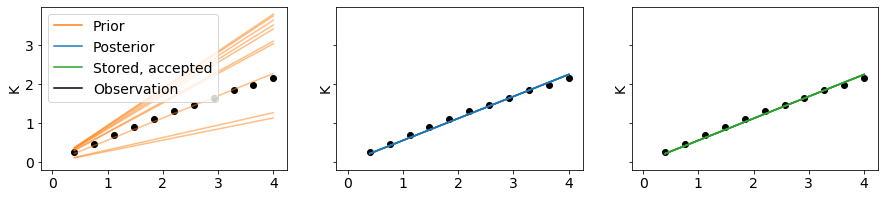

In [12]:
plot_samples(history, model_naive, prior, measured_data)

The parameter optimum has converged on a best-fit line through the data points.

## ABC under measurement uncertainty

Now we change the ABC acceptance criterion proportional to the probability density of the expected error due to noise. We assume this error is distributed $\sim\mathcal{N}(0,\sigma_e^2)$ where $\sigma_e^2$ is included as a parameter to be inferred using ABC.

For the naive model, we would expect $\theta$ to converge on the same value as previously, and $\sigma_e^2$ to converge to a value greater than the actual noise in the observed measurements.

In [13]:
from ionchannelABC import DiscrepancyKernel

INFO:myokit:Loading Myokit version 1.29.1


In [17]:
acceptor = pyabc.StochasticAcceptor()
eps_keys = ['measure_var']
kernel = DiscrepancyKernel(eps_keys=eps_keys,
                           exp_mask=[0])
eps = pyabc.Temperature()
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=16)
transition = pyabc.transition.LocalTransition()

In [18]:
augmented_prior = pyabc.Distribution({'theta': pyabc.RV("uniform", 0., 1.),
                                      'measure_var': pyabc.RV("uniform", 0., 0.2**2)})

In [19]:
abc = pyabc.ABCSMC(model_naive, augmented_prior, kernel,
                   eps=eps, acceptor=acceptor,
                   sampler=sampler,
                   population_size=population_size,
                   transitions=transition)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history = abc.run(max_nr_populations=20)

INFO:History:Start <ABCSMC(id=249, start_time=2019-12-04 11:14:32.914672, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 79.20987445548062.
INFO:ABC:Acceptance rate: 100 / 290 = 3.4483e-01.
INFO:ABC:t: 1, eps: 15.281487873633825.
INFO:ABC:Acceptance rate: 100 / 417 = 2.3981e-01.
INFO:ABC:t: 2, eps: 8.422234071923462.
INFO:ABC:Acceptance rate: 100 / 320 = 3.1250e-01.
INFO:ABC:t: 3, eps: 5.74800387043554.
INFO:ABC:Acceptance rate: 100 / 357 = 2.8011e-01.
INFO:ABC:t: 4, eps: 4.596847607687467.
INFO:ABC:Acceptance rate: 100 / 333 = 3.0030e-01.
INFO:ABC:t: 5, eps: 4.1523705228876215.
INFO:ABC:Acceptance rate: 100 / 444 = 2.2523e-01.
INFO:ABC:t: 6, eps: 3.7508706902772517.
INFO:ABC:Acceptance rate: 100 / 388 = 2.5773e-01.
INFO:ABC:t: 7, eps: 3.3881925655798963.
INFO:ABC:Acceptance rate: 100 / 374 = 2.6738e-01.
INFO:ABC:t: 8, eps: 2.913714135793136.
INFO:ABC:Acceptance rate: 100 / 351 = 2.8490e-01.
INFO:ABC:t: 9, eps: 2.643775001557919.
INFO:ABC:Acceptance rate: 1

The estimate of the parameter is still wrong, but has a wider posterior distribution.

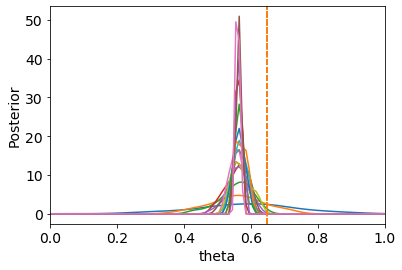

In [20]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="theta", t=t, refval=theta_true,
        xmin=0, xmax=1, numx=100, ax=ax)

(<Figure size 1080x216 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc803592110>,
       dtype=object))

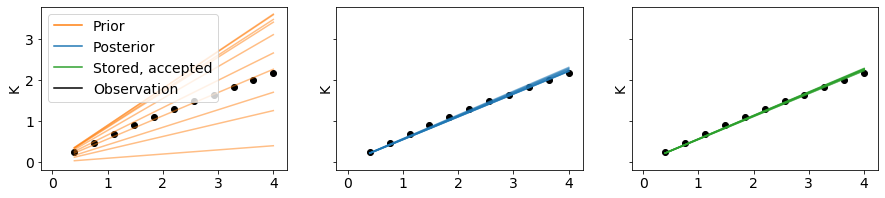

In [21]:
plot_samples(history, model_naive, augmented_prior, measured_data)

However, we also note that the estimate measurement variance is larger than only the measurement noise which was set as $\sigma_e^2=0.01^2$ in the problem set-up.

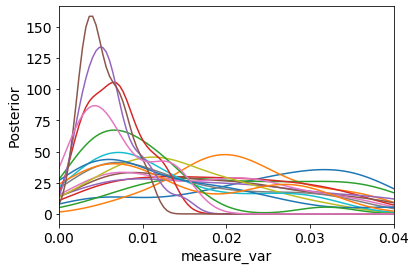

In [22]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="measure_var", t=t,
        xmin=0, xmax=0.2**2, numx=100, ax=ax)

For the true model, we expect to recover the correct values of $\theta$ and $\sigma_e^2$.

In [23]:
acceptor = pyabc.StochasticAcceptor()
eps_keys = ['measure_var']
exp_mask = [0]
kernel = DiscrepancyKernel(eps_keys=eps_keys, exp_mask=exp_mask)
eps = pyabc.Temperature()
transition = pyabc.LocalTransition()
population_size = pyabc.ConstantPopulationSize(nr_particles=100)

augmented_prior = pyabc.Distribution({'theta': pyabc.RV("uniform", 0., 1.),
                                      'measure_var': pyabc.RV("uniform", 0., 0.2**2)})
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=16)

abc = pyabc.ABCSMC(model_true, augmented_prior, kernel,
                   eps=eps, acceptor=acceptor,
                   sampler=sampler,
                   population_size=population_size,
                   transitions=transition)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history = abc.run(max_nr_populations=20)

INFO:History:Start <ABCSMC(id=250, start_time=2019-12-04 11:17:22.277211, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 45.42796924314892.
INFO:ABC:Acceptance rate: 100 / 432 = 2.3148e-01.
INFO:ABC:t: 1, eps: 17.066749552493505.
INFO:ABC:Acceptance rate: 100 / 401 = 2.4938e-01.
INFO:ABC:t: 2, eps: 12.745795924351611.
INFO:ABC:Acceptance rate: 100 / 330 = 3.0303e-01.
INFO:ABC:t: 3, eps: 10.973505223251419.
INFO:ABC:Acceptance rate: 100 / 524 = 1.9084e-01.
INFO:ABC:t: 4, eps: 9.447649844656674.
INFO:ABC:Acceptance rate: 100 / 730 = 1.3699e-01.
INFO:ABC:t: 5, eps: 8.13396319328441.
INFO:ABC:Acceptance rate: 100 / 1471 = 6.7981e-02.
INFO:ABC:t: 6, eps: 7.002943411066885.
INFO:ABC:Acceptance rate: 100 / 1647 = 6.0716e-02.
INFO:ABC:t: 7, eps: 6.029190845010789.
INFO:ABC:Acceptance rate: 100 / 2612 = 3.8285e-02.
INFO:ABC:t: 8, eps: 5.190837639515337.
INFO:ABC:Acceptance rate: 100 / 2536 = 3.9432e-02.
INFO:ABC:t: 9, eps: 4.4690566433315375.
INFO:ABC:Acceptance rat

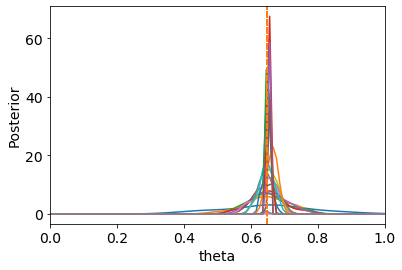

In [24]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="theta", t=t, refval=theta_true,
        xmin=0, xmax=1, numx=100, ax=ax)

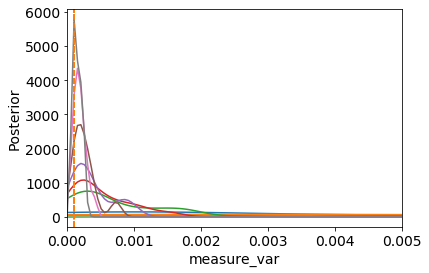

In [27]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="measure_var", t=t, refval={'measure_var': 0.01**2},
        xmin=0, xmax=0.005, numx=100, ax=ax)

## ABC under measurement uncertainty and model discrepancy

Now, we assume we know the measurement uncertainty is $\mathcal{N}(0,0.01^2)$ (as, for example, in data from a scientist with reported error bars from multiple experimental realisations).

We also assume that there is model discrepancy adds additional variance $\mathcal{N}(0,\sigma_m^2)$ and infer this parameter in addition to $\theta$.

In [28]:
eps_keys = ['model_var']
exp_mask = [0]
measure_var = [0.01**2,]*len(x) # sum of normal errors on each observation
augmented_prior = pyabc.Distribution({'theta': pyabc.RV("uniform", 0., 1.),
                                      'model_var': pyabc.RV("uniform", 0., 0.2**2)})

In [30]:
acceptor = pyabc.StochasticAcceptor()
kernel = DiscrepancyKernel(measure_var=measure_var,
                                 eps_keys=eps_keys,
                                 exp_mask=exp_mask)
eps = pyabc.Temperature()
population_size = pyabc.ConstantPopulationSize(nr_particles=100)
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=16)
transition = pyabc.LocalTransition()

In [31]:
abc = pyabc.ABCSMC(model_naive, augmented_prior, kernel, 
                   eps=eps, acceptor=acceptor,
                   sampler=sampler,
                   population_size=population_size,
                   transitions=transition)
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history = abc.run(max_nr_populations=20)

INFO:History:Start <ABCSMC(id=251, start_time=2019-12-04 11:21:11.444687, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 73.08227723233661.
INFO:ABC:Acceptance rate: 100 / 290 = 3.4483e-01.
INFO:ABC:t: 1, eps: 10.496272189130208.
INFO:ABC:Acceptance rate: 100 / 361 = 2.7701e-01.
INFO:ABC:t: 2, eps: 5.412399223742464.
INFO:ABC:Acceptance rate: 100 / 358 = 2.7933e-01.
INFO:ABC:t: 3, eps: 3.9514849483585484.
INFO:ABC:Acceptance rate: 100 / 407 = 2.4570e-01.
INFO:ABC:t: 4, eps: 3.626292328816065.
INFO:ABC:Acceptance rate: 100 / 438 = 2.2831e-01.
INFO:ABC:t: 5, eps: 3.32786186101829.
INFO:ABC:Acceptance rate: 100 / 466 = 2.1459e-01.
INFO:ABC:t: 6, eps: 3.053991118701631.
INFO:ABC:Acceptance rate: 100 / 459 = 2.1786e-01.
INFO:ABC:t: 7, eps: 2.802658927151057.
INFO:ABC:Acceptance rate: 100 / 436 = 2.2936e-01.
INFO:ABC:t: 8, eps: 2.572010446866961.
INFO:ABC:Acceptance rate: 100 / 416 = 2.4038e-01.
INFO:ABC:t: 9, eps: 2.3603434847911617.
INFO:ABC:Acceptance rate: 10

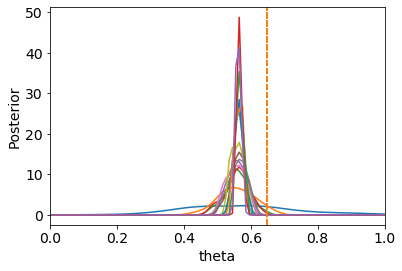

In [37]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="theta", t=t, refval=theta_true,
        xmin=0., xmax=1., numx=100, ax=ax)

(<Figure size 1080x216 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc809737fd0>,
       dtype=object))

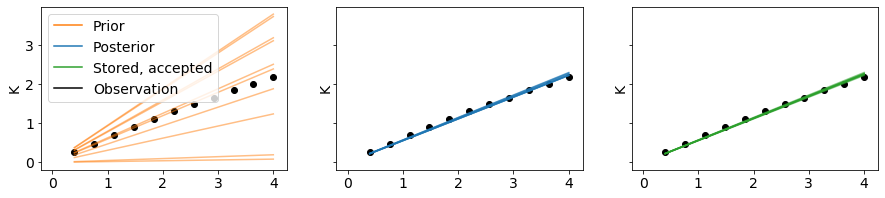

In [35]:
plot_samples(history, model_naive, augmented_prior, measured_data)

We note a non-zero modal additional variance to account for model discrepancy.

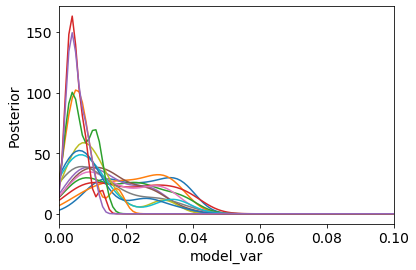

In [36]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="model_var", t=t,
        xmin=0., xmax=0.1, numx=100, ax=ax)

We can compare this to running the same calibration with the true model.

In [39]:
acceptor = pyabc.StochasticAcceptor()
kernel = DiscrepancyKernel(measure_var=measure_var,
                           eps_keys=eps_keys,
                           exp_mask=exp_mask)
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=16)
eps = pyabc.Temperature()
population_size = pyabc.ConstantPopulationSize(nr_particles=200)

In [40]:
abc = pyabc.ABCSMC(model_true, augmented_prior, kernel, 
                   eps=eps, acceptor=acceptor,
                   sampler=sampler,
                   population_size=population_size,
                   transitions=pyabc.LocalTransition())
abc.new(pyabc.create_sqlite_db_id(), measured_data)
history = abc.run(max_nr_populations=20)

INFO:History:Start <ABCSMC(id=252, start_time=2019-12-04 11:22:45.047226, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:ABC:t: 0, eps: 51.57509067768296.
INFO:ABC:Acceptance rate: 200 / 703 = 2.8450e-01.
INFO:ABC:t: 1, eps: 19.534504065948433.
INFO:ABC:Acceptance rate: 200 / 784 = 2.5510e-01.
INFO:ABC:t: 2, eps: 16.5611749918785.
INFO:ABC:Acceptance rate: 200 / 826 = 2.4213e-01.
INFO:ABC:t: 3, eps: 14.040413628402264.
INFO:ABC:Acceptance rate: 200 / 1377 = 1.4524e-01.
INFO:ABC:t: 4, eps: 11.903335056437541.
INFO:ABC:Acceptance rate: 200 / 1757 = 1.1383e-01.
INFO:ABC:t: 5, eps: 10.09153926770308.
INFO:ABC:Acceptance rate: 200 / 2318 = 8.6281e-02.
INFO:ABC:t: 6, eps: 8.555515265994025.
INFO:ABC:Acceptance rate: 200 / 3292 = 6.0753e-02.
INFO:ABC:t: 7, eps: 7.253288078748865.
INFO:ABC:Acceptance rate: 200 / 4511 = 4.4336e-02.
INFO:ABC:t: 8, eps: 6.149271705753641.
INFO:ABC:Acceptance rate: 200 / 5141 = 3.8903e-02.
INFO:ABC:t: 9, eps: 5.213296659479274.
INFO:ABC:Acceptance ra

We recovery the correct distribution for the parameter in the model.

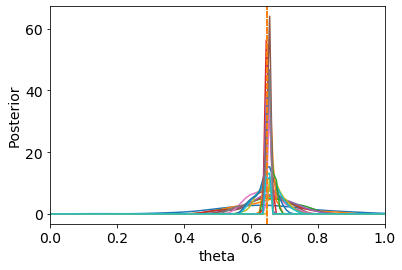

In [43]:
_, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="theta", t=t, refval=theta_true,
        xmin=0., xmax=1., numx=100, ax=ax)

(<Figure size 1080x216 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc809721250>,
       dtype=object))

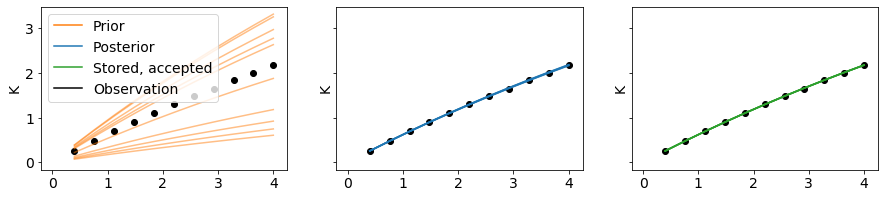

In [44]:
plot_samples(history, model_true, augmented_prior, measured_data)

The additional variance due to model discrepancy is tending towards a zero modal value, implying the correct model.

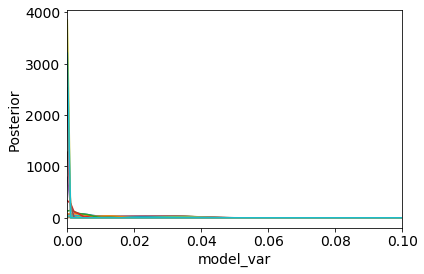

In [45]:
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    pyabc.visualization.plot_kde_1d_highlevel(
        history, x="model_var", t=t,
        xmin=0., xmax=0.1, numx=100, ax=ax)